# Libraries

In [109]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from textblob import TextBlob
from imblearn.over_sampling import SMOTE
import numpy as np



# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

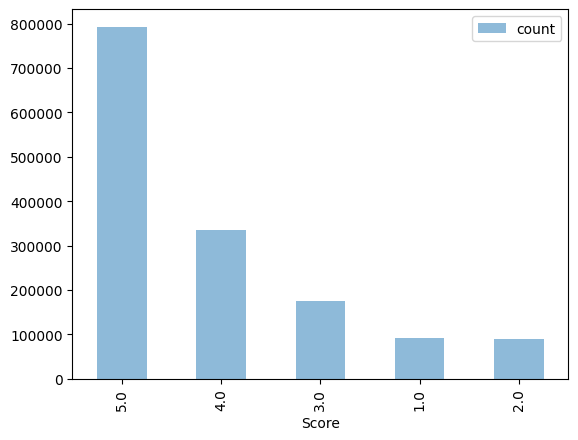


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [110]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [111]:
def add_features_to(df):
    # This is where you can do all your feature extraction
    print("Starting feature extraction...")

    # Track progress for Helpfulness
    print("Calculating Helpfulness...")
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Track progress for ReviewLengthWords
    print("Calculating ReviewLengthWords...")
    df['ReviewLengthWords'] = df['Text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

    # Sentiment calculation with progress tracking
    def get_sentiment(text, index):
        if isinstance(text, str):  # Check if the text is a string
            blob = TextBlob(text)
            sentiment = blob.sentiment.polarity  # Get the sentiment polarity (-1 to 1)
        else:
            sentiment = 0  # Return 0 for null or non-string values
        if index % 100000 == 0:  # Print progress every 1000 rows
            print(f"Processed {index} rows for sentiment...")
        return sentiment

    print("Calculating Sentiment...")
    df['Sentiment'] = df.apply(lambda row: get_sentiment(row['Text'], row.name), axis=1)

    print("Feature extraction complete.")
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

In [112]:
def AnalyzeFeature(df, feature):
    # Group by 'Score' and calculate the average of the specified feature for each score
    avg_feature_by_score = df.groupby('Score')[feature].mean()

    print(f"Average {feature} by Score:")
    print(avg_feature_by_score)

    # Plot the average of the specified feature by score
    plt.figure(figsize=(8, 6))
    avg_feature_by_score.plot(kind='bar')
    plt.title(f'Average {feature} by Score')
    plt.xlabel('Score')
    plt.ylabel(f'Average {feature}')
    plt.show()

    # Correlation between the specified feature and 'Score'
    correlation = df[[feature, 'Score']].corr()

    print(f"Correlation between {feature} and Score:")
    print(correlation)

Average HelpfulnessNumerator by Score:
Score
1.0    5.819103
2.0    3.434298
3.0    2.930192
4.0    3.377692
5.0    3.550387
Name: HelpfulnessNumerator, dtype: float64


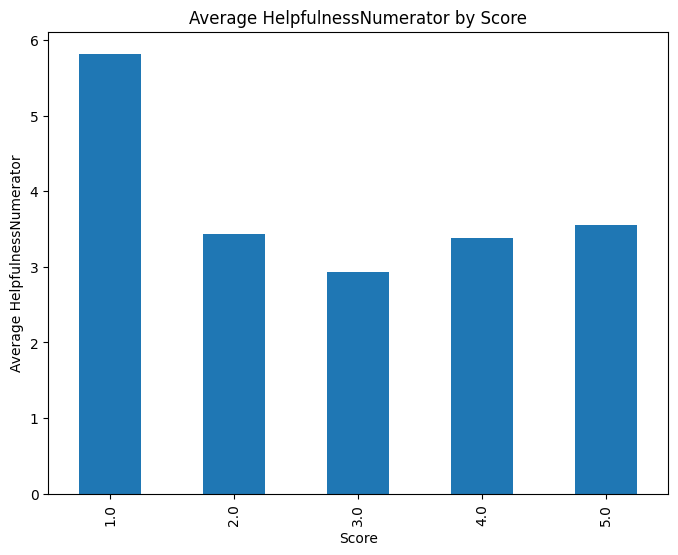

Correlation between HelpfulnessNumerator and Score:
                      HelpfulnessNumerator     Score
HelpfulnessNumerator              1.000000 -0.015887
Score                            -0.015887  1.000000
Average HelpfulnessDenominator by Score:
Score
1.0    15.580722
2.0     7.648543
3.0     4.901262
4.0     4.306171
5.0     4.367424
Name: HelpfulnessDenominator, dtype: float64


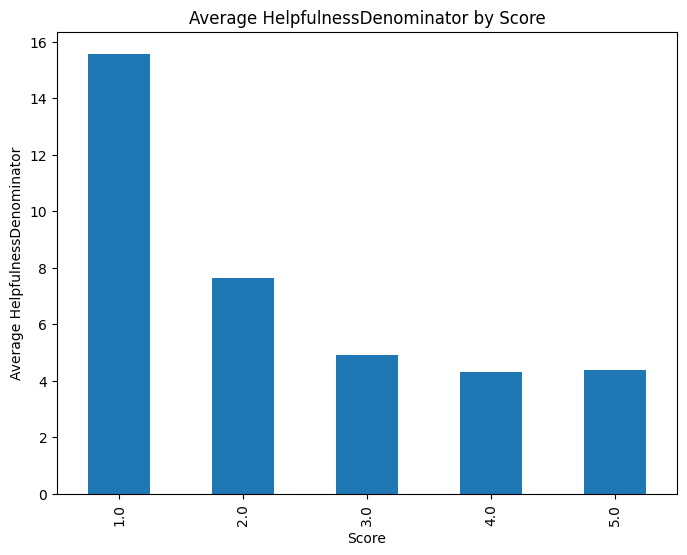

Correlation between HelpfulnessDenominator and Score:
                        HelpfulnessDenominator    Score
HelpfulnessDenominator                 1.00000 -0.10764
Score                                 -0.10764  1.00000
Average Helpfulness by Score:
Score
1.0    0.362576
2.0    0.365012
3.0    0.370858
4.0    0.432851
5.0    0.400386
Name: Helpfulness, dtype: float64


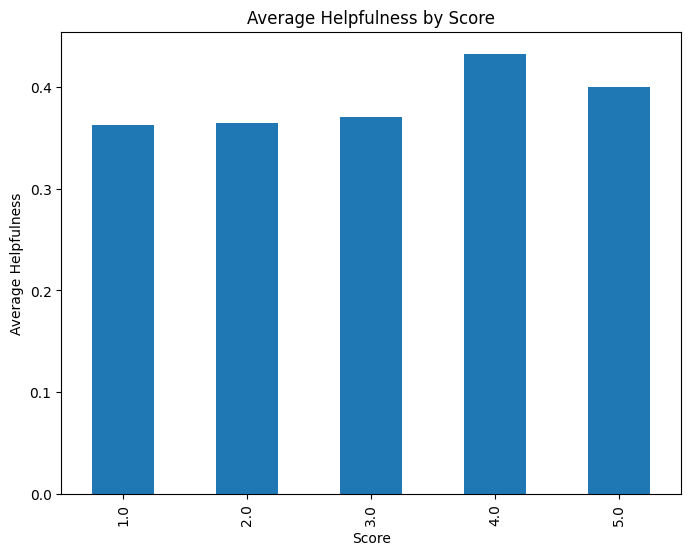

Correlation between Helpfulness and Score:
             Helpfulness     Score
Helpfulness     1.000000  0.029479
Score           0.029479  1.000000
Average ReviewLengthWords by Score:
Score
1.0    153.054260
2.0    196.890341
3.0    196.586142
4.0    192.119343
5.0    137.888379
Name: ReviewLengthWords, dtype: float64


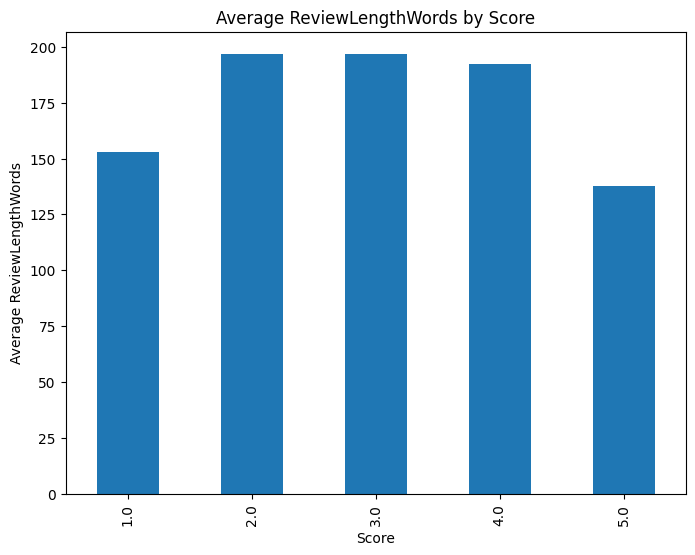

Correlation between ReviewLengthWords and Score:
                   ReviewLengthWords     Score
ReviewLengthWords           1.000000 -0.079194
Score                      -0.079194  1.000000
Average Sentiment by Score:
Score
1.0   -0.011499
2.0    0.066287
3.0    0.148364
4.0    0.213358
5.0    0.288974
Name: Sentiment, dtype: float64


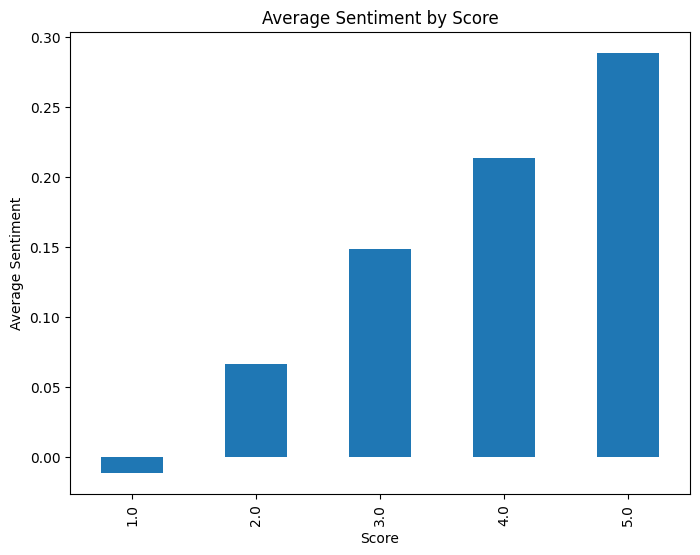

Correlation between Sentiment and Score:
           Sentiment     Score
Sentiment   1.000000  0.422047
Score       0.422047  1.000000


In [113]:
numericFeatures = ["HelpfulnessNumerator", "HelpfulnessDenominator", "Helpfulness", "ReviewLengthWords", "Sentiment"]
for ft in numericFeatures:
  AnalyzeFeature(X_train, ft)

# Sample + Split into training and testing set

In [114]:
# filter out num-numeric columns
numericFeatures = ["HelpfulnessNumerator", "HelpfulnessDenominator", "Helpfulness", "ReviewLengthWords", "Sentiment", "Score"]
X_train = X_train[numericFeatures]
X_train = X_train.fillna(0)  # or use any appropriate method to handle NaNs

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Print the initial distribution of Y_train
print("Original class distribution:")
print(Y_train.value_counts())

# Apply SMOTE for oversampling the minority classes
smote = SMOTE(random_state=0)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train, Y_train)

# Print the new distribution of Y_train after balancing
print("Balanced class distribution:")
print(Y_train_balanced.value_counts())

# Reduce the size of X_train and Y_train (for faster testing)
X_train_balanced = X_train_balanced.sample(frac=0.1, random_state=0)  # Use 10% of the balanced training set
Y_train_balanced = Y_train_balanced.loc[X_train_balanced.index]  # Ensure the labels match the reduced training set
X_train = X_train.sample(frac=0.1, random_state=0)  # Use 10% of the balanced training set
Y_train = Y_train.loc[X_train.index]  # Ensure the labels match the reduced training set

# Print the size of the reduced dataset and a sample
print(f"Reduced X_train size: {X_train_balanced.shape}")
print("Sample of reduced X_train:")
print(X_train_balanced.head())

Original class distribution:
Score
5.0    595120
4.0    251418
3.0    131911
1.0     68284
2.0     67272
Name: count, dtype: int64
Balanced class distribution:
Score
5.0    595120
2.0    595120
1.0    595120
4.0    595120
3.0    595120
Name: count, dtype: int64
Reduced X_train size: (297560, 5)
Sample of reduced X_train:
         HelpfulnessNumerator  HelpfulnessDenominator  Helpfulness  \
732558                      4                       5     0.800000   
1950472                     1                       2     0.500000   
2145440                     0                       1     0.000000   
281797                      0                       0     0.000000   
2320954                     7                      16     0.438459   

         ReviewLengthWords  Sentiment  
732558                  46   0.575000  
1950472                556   0.056802  
2145440                 27  -0.077475  
281797                  23   0.218519  
2320954                132   0.112801  


# Feature Selection

In [162]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'Sentiment', 'ReviewLengthWords']
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'Sentiment']

X_test_select = X_test[features]
X_submission_select = X_submission[features]

X_train_select = X_train[features]
Y_train_select = Y_train
# X_train_select = X_train_balanced[features]
# Y_train_select = Y_train_balanced



# Model Creation

In [181]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=99).fit(X_train_select, Y_train_select)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)


# Model Evaluation

Accuracy on testing set =  0.5545839886248572



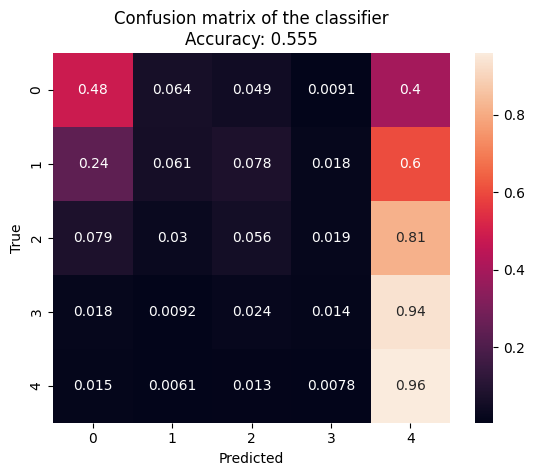

In [183]:
# Evaluate your model on the testing set
accuracy = accuracy_score(Y_test, Y_test_predictions)
print("Accuracy on testing set = ", accuracy)
print()

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title(f'Confusion matrix of the classifier\nAccuracy: {accuracy:.3f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [118]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)